In [1]:
using BenchmarkTools
using StellarChem
using StellarConstants
using StellarEOS
using StellarOpacity
using StellarEvolution

In [2]:
isotope_list = StellarChem.get_isotope_list()

Dict{Symbol, Isotope} with 3352 entries:
  :Ne26  => Isotope(10, 26, "Ne", 26.0005)
  :C22   => Isotope(6, 22, "C", 22.0575)
  :Pr143 => Isotope(59, 143, "Pr", 142.911)
  :Re163 => Isotope(75, 163, "Re", 162.972)
  :Cu52  => Isotope(29, 52, "Cu", 51.9967)
  :Co50  => Isotope(27, 50, "Co", 49.9809)
  :Sr74  => Isotope(38, 74, "Sr", 73.9562)
  :Pt188 => Isotope(78, 188, "Pt", 187.959)
  :No258 => Isotope(102, 258, "No", 258.098)
  :Pb210 => Isotope(82, 210, "Pb", 209.984)
  :Dy148 => Isotope(66, 148, "Dy", 147.927)
  :Hg200 => Isotope(80, 200, "Hg", 199.968)
  :Ir182 => Isotope(77, 182, "Ir", 181.958)
  :Md246 => Isotope(101, 246, "Md", 246.082)
  :Lr251 => Isotope(103, 251, "Lr", 251.094)
  :Cu75  => Isotope(29, 75, "Cu", 74.9415)
  :Ce144 => Isotope(58, 144, "Ce", 143.914)
  :Xe125 => Isotope(54, 125, "Xe", 124.906)
  :Ni66  => Isotope(28, 66, "Ni", 65.9291)
  ⋮      => ⋮

In [3]:
function equationHSE(sm, k, varm1::Vector{<:TT}, var00::Vector{<:TT}, varp1::Vector{<:TT},
                            eosm1::Vector{<:TT}, eos00::Vector{<:TT}, eosp1::Vector{<:TT},
                            κm1::TT, κ00::TT, κp1::TT)::TT where{TT<:Real}
    if k==sm.nz
        lnP₀ = var00[sm.vari[:lnP]]
        r₀ = exp(var00[sm.vari[:lnr]])
        g₀ = CGRAV*sm.mstar/r₀^2
        return lnP₀ -log(2g₀/(3κ00)) # Eddington gray, ignoring radiation pressure term
    end
    lnP₊ = varp1[sm.vari[:lnP]]
    lnP₀ = var00[sm.vari[:lnP]]
    lnPface = (sm.dm[k]*lnP₀ + sm.dm[k+1]*lnP₊)/(sm.dm[k]+sm.dm[k+1])
    r₀ = exp(var00[sm.vari[:lnr]])
    dm = (sm.m[k+1]-sm.m[k])
    
    return (exp(lnPface)*(lnP₊ - lnP₀)/dm + CGRAV*sm.m[k]/(4π*r₀^4))/(CGRAV*sm.m[k]/(4π*r₀^4))
end

function equationT(sm, k, varm1::Vector{<:TT}, var00::Vector{<:TT}, varp1::Vector{<:TT},
                          eosm1::Vector{<:TT}, eos00::Vector{<:TT}, eosp1::Vector{<:TT},
                          κm1::TT, κ00::TT, κp1::TT)::TT where{TT<:Real}
    if k==sm.nz
        lnT₀ = var00[sm.vari[:lnT]]
        L₀ = var00[sm.vari[:lum]]*LSUN
        r₀ = exp(var00[sm.vari[:lnr]])
        return lnT₀ - log(L₀/(BOLTZ_SIGMA*4π*r₀^2))/4 # Eddington gray, ignoring radiation pressure term
    end
    κface = exp((sm.dm[k]*log(κ00) + sm.dm[k+1]*log(κp1))/(sm.dm[k]+sm.dm[k+1]))
    L₀ = var00[sm.vari[:lum]]*LSUN
    r₀ = exp(var00[sm.vari[:lnr]])
    Pface = exp((sm.dm[k]*var00[sm.vari[:lnP]] + sm.dm[k+1]*varp1[sm.vari[:lnP]])/(sm.dm[k]+sm.dm[k+1]))
    lnT₊ = varp1[sm.vari[:lnT]]
    lnT₀ = var00[sm.vari[:lnT]]
    Tface = exp((sm.dm[k]*lnT₀ + sm.dm[k+1]*lnT₊)/(sm.dm[k]+sm.dm[k+1]))

    ∇ᵣ = 3κface*L₀*Pface/(16π*CRAD*CLIGHT*CGRAV*sm.m[k]*Tface^4)
    ∇ₐ = (sm.dm[k]*eos00[7] + sm.dm[k+1]*eosp1[7])/(sm.dm[k]+sm.dm[k+1])

    if (∇ᵣ < ∇ₐ)
        return (Tface*(lnT₊ - lnT₀)/sm.dm[k] + CGRAV*sm.m[k]*Tface/(4π*r₀^4*Pface)*∇ᵣ)/(CGRAV*sm.m[k]*Tface/(4π*r₀^4*Pface)) # only radiative transport
    else
        return (Tface*(lnT₊ - lnT₀)/sm.dm[k] + CGRAV*sm.m[k]*Tface/(4π*r₀^4*Pface)*∇ₐ)/(CGRAV*sm.m[k]*Tface/(4π*r₀^4*Pface)) # only radiative transport
    end
end

function equationLuminosity(sm, k, varm1::Vector{<:TT}, var00::Vector{<:TT}, varp1::Vector{<:TT},
                          eosm1::Vector{<:TT}, eos00::Vector{<:TT}, eosp1::Vector{<:TT},
                          κm1::TT, κ00::TT, κp1::TT)::TT where{TT<:Real}
    L₋::TT = 0 # central luminosity is zero at first cell
    if k>1
        L₋ = varm1[sm.vari[:lum]]*LSUN # change it if not at first cell
    end
    L₀ = var00[sm.vari[:lum]]*LSUN
    ρ₀ = eos00[1]
    cₚ = eos00[5]
    δ = eos00[6]
    dTdt = (exp(var00[sm.vari[:lnT]]) - exp(sm.ssi.lnT[k]))/sm.ssi.dt
    dPdt = (exp(var00[sm.vari[:lnP]]) - exp(sm.ssi.lnP[k]))/sm.ssi.dt

    ϵnuc = 0.1*var00[sm.vari[:H1]]^2*ρ₀*(exp(var00[sm.vari[:lnT]])/1e6)^4 + 0.1*var00[sm.vari[:H1]]*ρ₀*(exp(var00[sm.vari[:lnT]])/1e7)^18

    return ((L₀-L₋)/sm.dm[k]-ϵnuc+cₚ*dTdt -(δ/ρ₀)*dPdt) # no nuclear reactions or neutrinos
end

function equationContinuity(sm, k, varm1::Vector{<:TT}, var00::Vector{<:TT}, varp1::Vector{<:TT},
                                   eosm1::Vector{<:TT}, eos00::Vector{<:TT}, eosp1::Vector{<:TT},
                                   κm1::TT, κ00::TT, κp1::TT)::TT where{TT<:Real}
    ρ₀ = eos00[1]
    r₀ = exp(var00[sm.vari[:lnr]])
    r₋::TT = 0 # central radius is zero at first cell
    if k>1
        r₋ = exp(varm1[sm.vari[:lnr]]) # change it if not at first cell
    end
    
    dm = sm.m[k] # this is only valid for k=1
    if k>1
        dm = dm-sm.m[k-1]
    end

    #expected_r₀ = r₋ + dm/(4π*r₋^2*ρ)
    expected_dr³_dm = 3/(4π*ρ₀)
    actual_dr³_dm = (r₀^3-r₋^3)/dm
    
    return (expected_dr³_dm - actual_dr³_dm)*ρ₀
end

#  To test performance, include 8 isotopes similar to basic.net in MESA.
#  of course we are keeping these fixed now, but it lets us test their impact on the
#  computation of the jacobian

function equationH1(sm, k, varm1::Vector{<:TT}, var00::Vector{<:TT}, varp1::Vector{<:TT},
                                    eosm1::Vector{<:TT}, eos00::Vector{<:TT}, eosp1::Vector{<:TT},
                                    κm1::TT, κ00::TT, κp1::TT)::TT where{TT<:Real}
    ρ₀ = eos00[1]
    ϵnuc = 0.1*var00[sm.vari[:H1]]^2*ρ₀*(exp(var00[sm.vari[:lnT]])/1e6)^4 + 0.1*var00[sm.vari[:H1]]*ρ₀*(exp(var00[sm.vari[:lnT]])/1e7)^18
    rate_per_unit_mass = 4*ϵnuc/((4*isotope_list[:H1].mass-isotope_list[:He4].mass)*AMU*CLIGHT^2)

    Xi = sm.ssi.ind_vars[(k-1)*sm.nvars+sm.vari[:H1]]

    return (var00[sm.vari[:H1]]-Xi)/sm.ssi.dt + isotope_list[:H1].mass*AMU*rate_per_unit_mass
end

function equationHe4(sm, k, varm1::Vector{<:TT}, var00::Vector{<:TT}, varp1::Vector{<:TT},
                                    eosm1::Vector{<:TT}, eos00::Vector{<:TT}, eosp1::Vector{<:TT},
                                    κm1::TT, κ00::TT, κp1::TT)::TT where{TT<:Real}
    return  var00[sm.vari[:He4]] + var00[sm.vari[:H1]] - 1.0
end

equationHe4 (generic function with 1 method)

In [4]:
nvars = 6
nspecies = 2
varnames = [:lnP,:lnT,:lnr,:lum,:H1, :He4]
structure_equations=[equationHSE, equationT,
                        equationContinuity, equationLuminosity,
                        equationH1, equationHe4]
nz = 1000
eos = StellarEOS.IdealEOS(false)
opacity = StellarOpacity.SimpleElectronScatteringOpacity()
sm = StellarModel(varnames, structure_equations, nvars, nspecies, nz, eos, opacity);

In [5]:
StellarEvolution.n1_polytrope_initial_condition(sm, MSUN, 100*RSUN)

StellarEvolution.set_end_step_info(sm)
StellarEvolution.cycle_step_info(sm)
StellarEvolution.set_start_step_info(sm)

StellarEvolution.eval_jacobian!(sm)
StellarEvolution.eval_eqs!(sm)

In [6]:
using LinearSolve
@benchmark begin
    $sm.linear_solver.A = $sm.jac
    $sm.linear_solver.b = $sm.eqs
    corr =solve($sm.linear_solver)
end

BenchmarkTools.Trial: 1013 samples with 1 evaluation.
 Range (min … max):  4.299 ms …   7.288 ms  ┊ GC (min … max): 0.00% … 15.17%
 Time  (median):     4.700 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   4.925 ms ± 573.773 μs  ┊ GC (mean ± σ):  4.22% ±  7.08%

    ▃▃▁▁▄▇█▄▄▄                                                 
  ▅▇████████████▇▇▆▄▅▅▃▃▃▂▂▂▁▁▁▂▂▂▂▂▂▃▂▂▂▃▄▃▃▄▂▄▃▂▃▂▂▂▂▂▂▁▁▂▂ ▃
  4.3 ms          Histogram: frequency by time        6.54 ms <

 Memory estimate: 8.73 MiB, allocs estimate: 41.

In [7]:
@benchmark StellarEvolution.eval_jacobian_row!(sm,1)

BenchmarkTools.Trial: 10000 samples with 5 evaluations.
 Range (min … max):  6.423 μs … 429.390 μs  ┊ GC (min … max):  0.00% … 95.19%
 Time  (median):     7.022 μs               ┊ GC (median):     0.00%
 Time  (mean ± σ):   8.403 μs ±  19.786 μs  ┊ GC (mean ± σ):  12.06% ±  5.03%

   ▁▅▇██▇▆▄▃▂▂▂▁▁                                             ▂
  ▄███████████████▇▇█▇▇███▇█▇▇▇▇▆▇▇▆▇▇▆▅▆▅▆▅▇█▇██▇▇▆▆▄▆▆▇▆▆▆▆ █
  6.42 μs      Histogram: log(frequency) by time        13 μs <

 Memory estimate: 25.28 KiB, allocs estimate: 211.

In [8]:
@benchmark StellarEvolution.eval_jacobian!(sm)

BenchmarkTools.Trial: 632 samples with 1 evaluation.
 Range (min … max):  2.471 ms … 36.256 ms  ┊ GC (min … max):  0.00% … 89.89%
 Time  (median):     4.186 ms              ┊ GC (median):     0.00%
 Time  (mean ± σ):   7.905 ms ±  9.662 ms  ┊ GC (mean ± σ):  45.51% ± 28.72%

    █                                                         
  ▃▄█▇▄▆▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▃▃▃▃▃ ▂
  2.47 ms        Histogram: frequency by time        35.3 ms <

 Memory estimate: 41.93 MiB, allocs estimate: 456470.

In [9]:
StellarEvolution.set_options!(sm.opt, "example_options.toml")
StellarEvolution.n1_polytrope_initial_condition(sm, MSUN, 100*RSUN)

StellarEvolution.do_evolution_loop(sm)

Found first model
(sm.model_number, i, real_max_corr, maximum(sm.eqs), dt_next / SECYEAR, sm.time / SECYEAR) = (0, 23, 5.668116017630781e-15, 3.3239189178857487e-11, 100.0, 0.0)


(sm.model_number, i, real_max_corr, maximum(sm.eqs), dt_next / SECYEAR, sm.time / SECYEAR) = (100, 4, 3.822181048178233e-14, 5.229132682416093e-10, 1.8460308816717623, 191.1320792131118)


(sm.model_number, i, real_max_corr, maximum(sm.eqs), dt_next / SECYEAR, sm.time / SECYEAR) = (200, 4, 5.299919063308831e-15, 2.78118861274379e-10, 34.06429425190625, 1130.5111124224725)


(sm.model_number, i, real_max_corr, maximum(sm.eqs), dt_next / SECYEAR, sm.time / SECYEAR) = (300, 4, 2.0422620089148364e-14, 1.0342350309500148e-9, 206.54389338429218, 17528.679584941612)


(sm.model_number, i, real_max_corr, maximum(sm.eqs), dt_next / SECYEAR, sm.time / SECYEAR) = (400, 4, 1.677436303770666e-14, 5.191509444557596e-10, 334.5584517574762, 43657.1010001367)


(sm.model_number, i, real_max_corr, maximum(sm.eqs), dt_next / SECYEAR, sm.time / SECYEAR) = (500, 4, 2.557135431464485e-14, 7.631574261424134e-10, 600.2130507089722, 88625.88654833642)


(sm.model_number, i, real_max_corr, maximum(sm.eqs), dt_next / SECYEAR, sm.time / SECYEAR) = (600, 4, 1.1813425150004618e-13, 6.450788792022877e-10, 1275.770488367888, 175733.7169121897)


(sm.model_number, i, real_max_corr, maximum(sm.eqs), dt_next / SECYEAR, sm.time / SECYEAR) = (700, 5, 2.570060386247916e-15, 1.1575109759576208e-9, 7711.288568881714, 456755.63799255673)


(sm.model_number, i, real_max_corr, maximum(sm.eqs), dt_next / SECYEAR, sm.time / SECYEAR) = (800, 7, 1.239737101981552e-14, 3.910437140763889e-9, 1.2731470403109617e6, 4.744484608180571e9)
Reached maximum central temperature


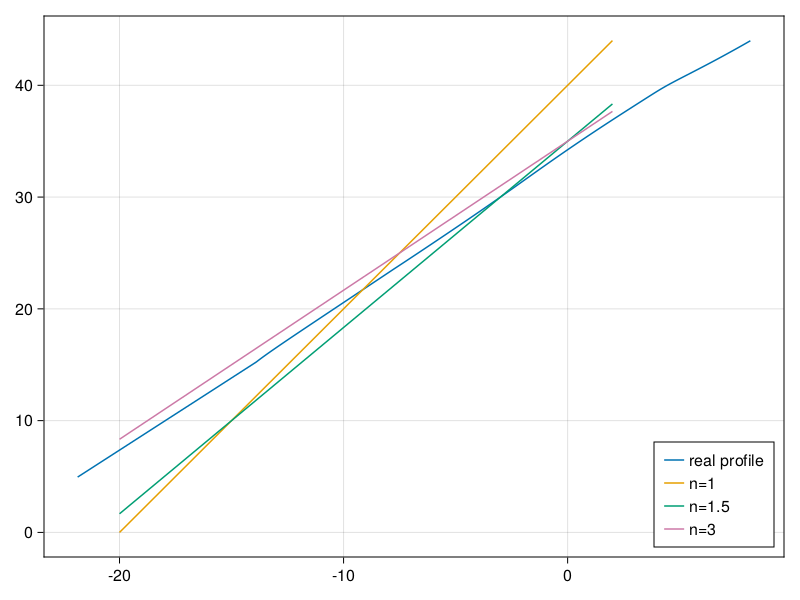

In [10]:
ρprofile = zeros(sm.nz)
for i in 1:sm.nz
    eos_result = get_EOS_resultsTP(sm.eos, sm.isotope_data,
    sm.ind_vars[(i-1)*sm.nvars+sm.vari[:lnT]], sm.ind_vars[(i-1)*sm.nvars+sm.vari[:lnP]], [1.0], [:H1])
    ρprofile[i] = eos_result[1]
end

using CairoMakie
f = Figure()
ax = Axis(f[1,1])
lines!(ax, log.(ρprofile), [sm.ind_vars[(i-1)*sm.nvars+sm.vari[:lnP]] for i in 1:sm.nz], label="real profile")
xvals = LinRange(-20,2,100)
lines!(ax,xvals,(1+1/1) .* xvals .+ 40, label="n=1")
lines!(ax,xvals,(1+1/(1.5)) .* xvals .+ 35, label="n=1.5")
lines!(ax,xvals,(1+1/3) .* xvals .+ 35, label="n=3")
axislegend(ax, position=:rb)
f

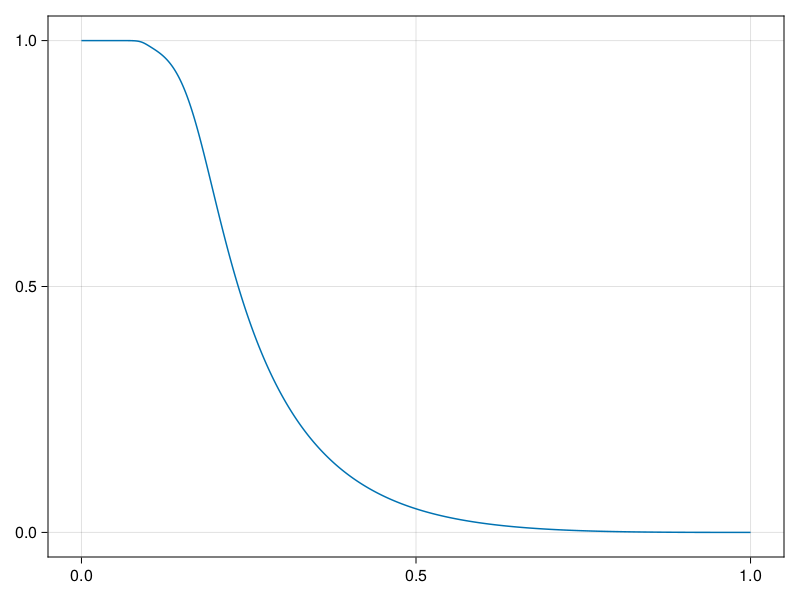

In [12]:
using CairoMakie
f = Figure()
ax = Axis(f[1,1])
lines!(ax, sm.m/MSUN, ([sm.ind_vars[(i-1)*sm.nvars+sm.vari[:He4]] for i in 1:sm.nz]))
f

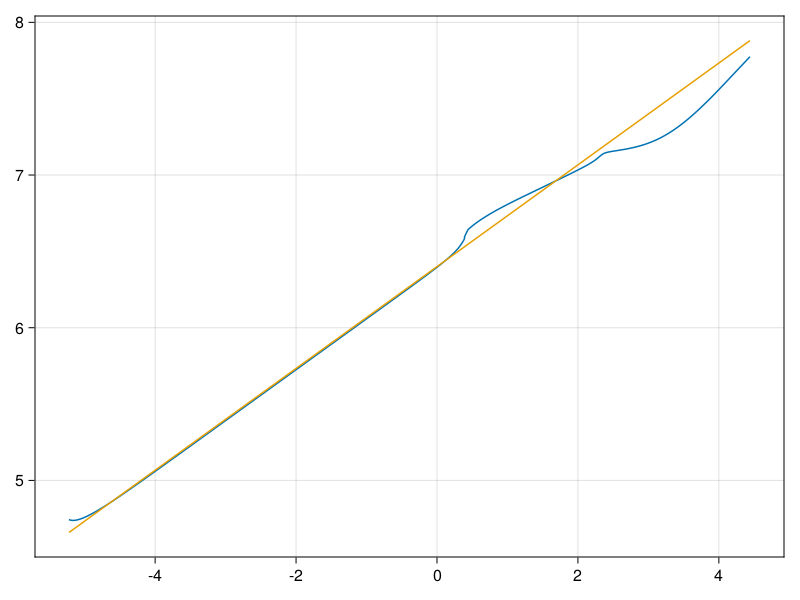

In [16]:
ρcenter = zeros(nsteps)
for i in 1:nsteps
    eos_result = get_EOS_resultsTP(sm.eos, sm.isotope_data,
        log(Tcenter[i]), log(Pcenter[i]), [1.0], [:H1])
    ρcenter[i] = eos_result[1]
end

using CairoMakie
using LaTeXStrings

f = Figure()
ax = Axis(f[1,1], xlabel="")
xvals = collect(LinRange(0,1,1000))
mass = xvals .* MSUN
#lines!(ax, xvals, P_const_ρ(mass,1,MSUN))
#lines!(ax, times, Pcenter)
lines!(ax, log10.(ρcenter), log10.(Tcenter))
lines!(ax, log10.(ρcenter), log10.(ρcenter)./3 .+ 6.4)
#lines!(ax, 1:10000, Lsurf)
#xlims!(ax,930,940)
f

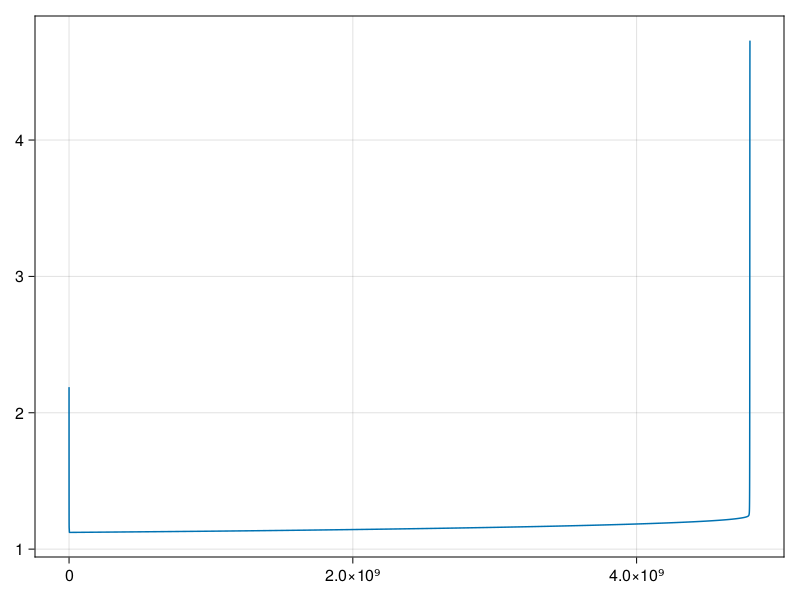

In [17]:
f = Figure()
ax = Axis(f[1,1], xlabel="")
xvals = collect(LinRange(0,1,1000))
mass = xvals .* MSUN
#lines!(ax, xvals, P_const_ρ(mass,1,MSUN))
#lines!(ax, times, Pcenter)
lines!(ax, times, log10.(Rsurf/RSUN)) # not contracting right now?
#lines!(ax, 1:10000, Lsurf)
#xlims!(ax,930,940)
f